# Introduction

In [4]:
# for formatting specific to this thesis
using ThesisUtils

# for plotting
using Plots
using StatPlots  # lets us plot DataFrames
using StatsBase
using LaTeXStrings

# for handling tables of data
using IterableTables
using CSVFiles
using DataFrames
using FileIO

# for water phase boundaries
using WaterData

## Exoplanet discovery method plots

In [5]:
# Load in data about exoplanet discoveries
d = DataFrame(load("figdata/exoplanet-discoveries.csv", skiplines_begin = 1))
transits = d[:PLANETDISCMETH] .== "Transit"
rv = d[:PLANETDISCMETH] .== "RV"
other = .!(transits .| rv)
d[other, :PLANETDISCMETH] = "Other"
categorical!(d, :PLANETDISCMETH)
levels!(d[:PLANETDISCMETH], ["Other", "RV", "Transit"])
sort!(d, cols = :PLANETDISCMETH)
ylabels = Dict(
    "Transit" => "Planets found by transit",
    "RV" => "Planets found by radial velocity",
    "Other" => "Planets found by other methods")

# choose colours for the plots
colors = [:firebrick, :slateblue, :seagreen]
color_dict = Dict(
    "Other" => colors[1],
    "RV" => colors[2],
    "Transit" => colors[3] );

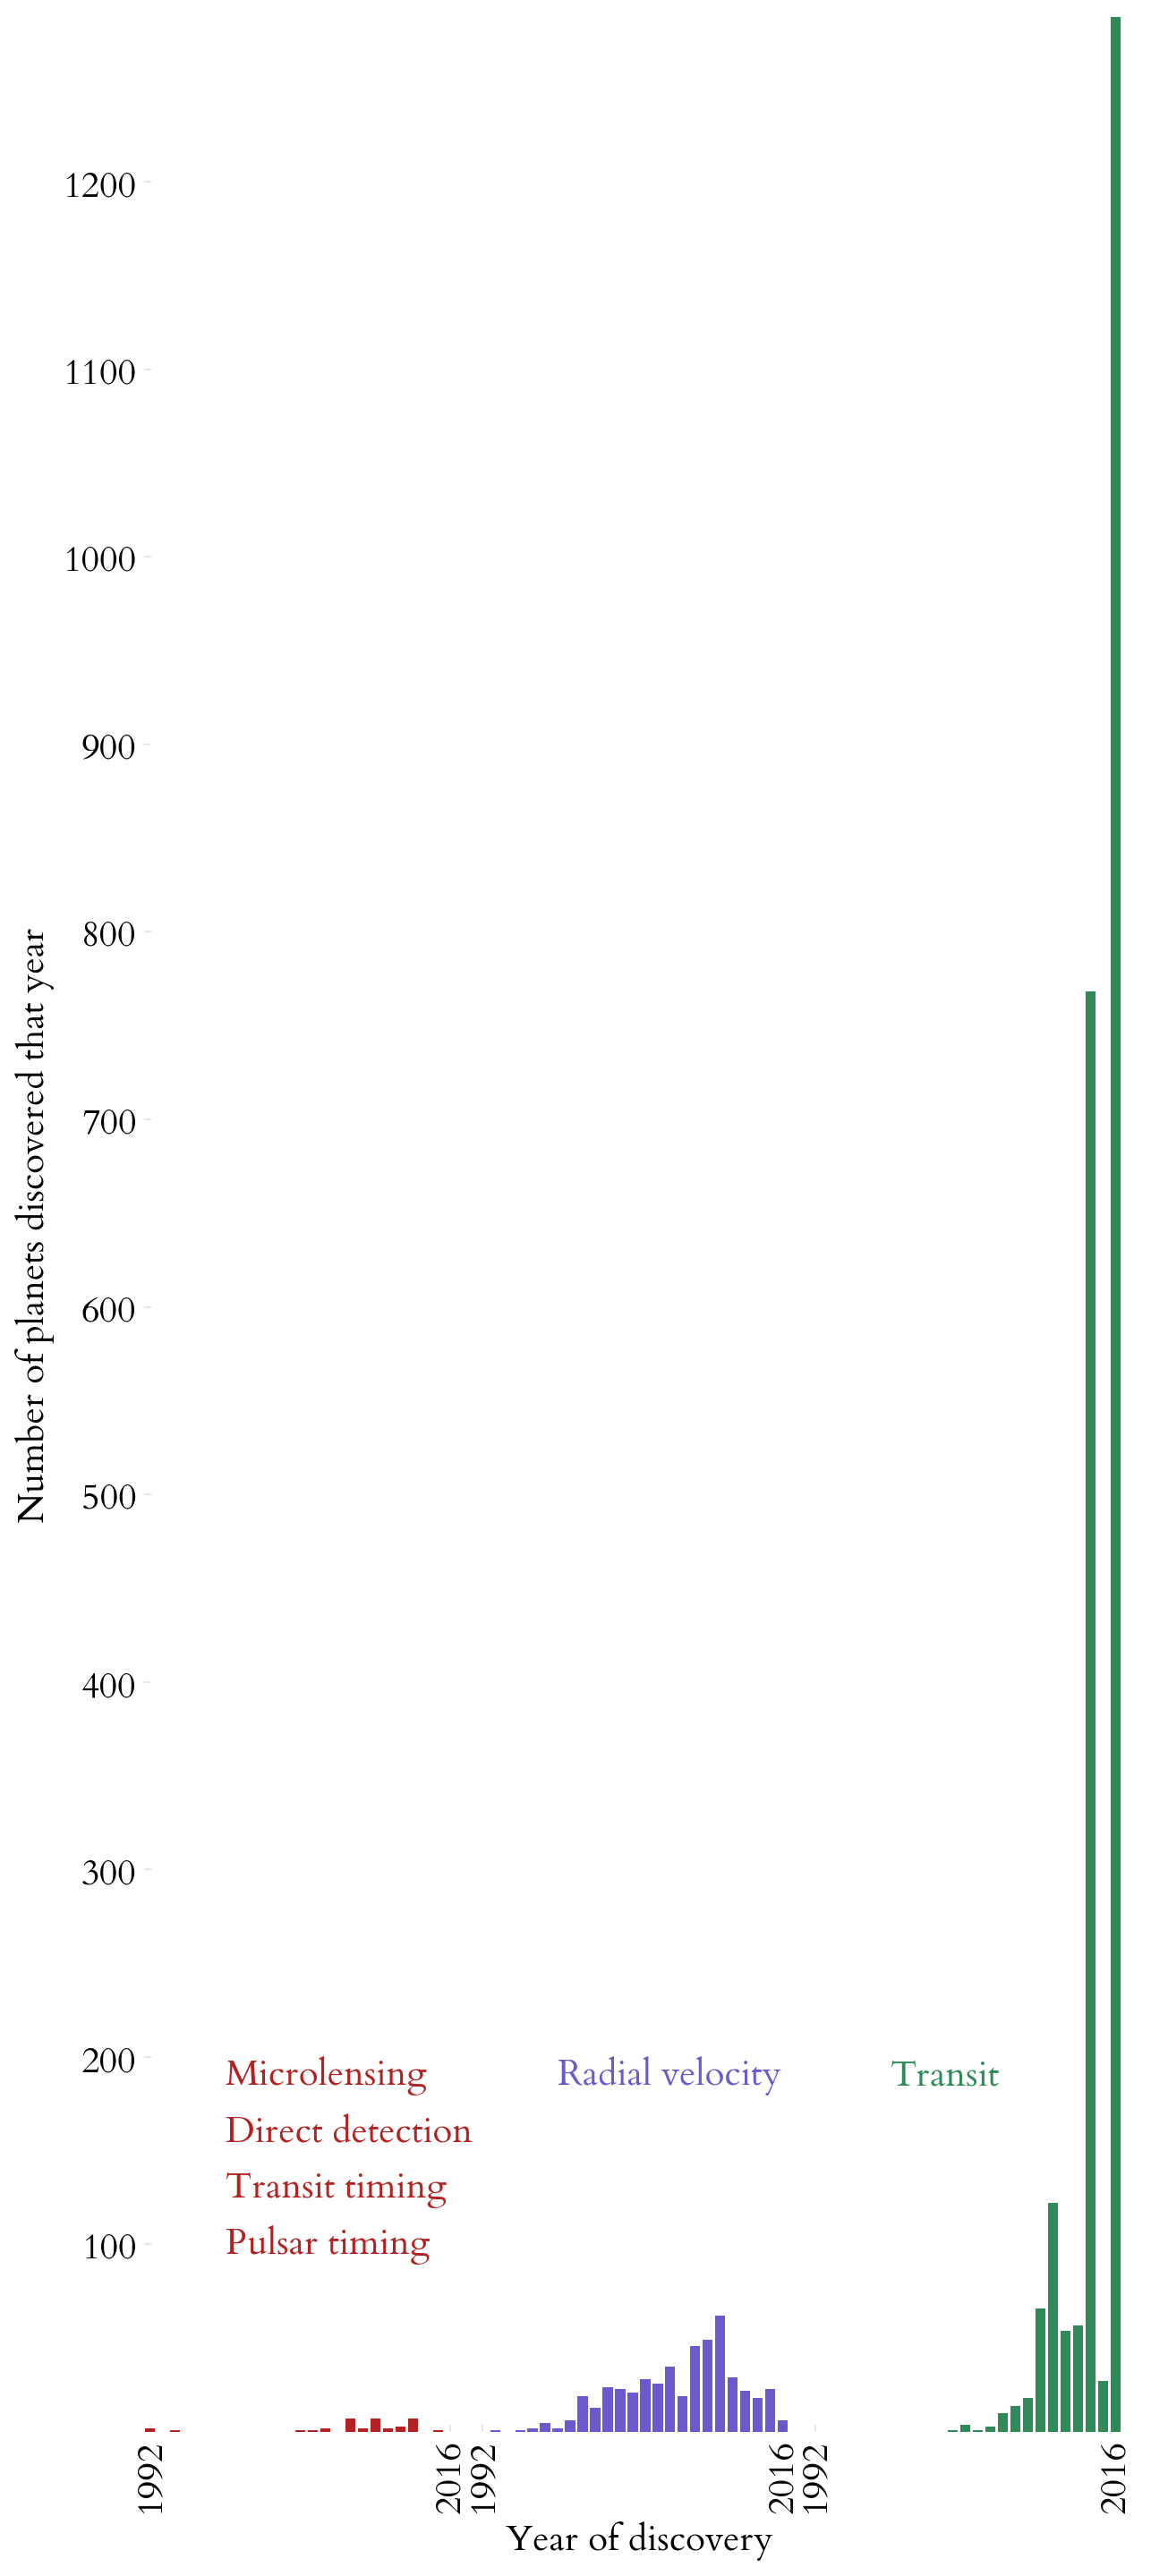

In [6]:
# make one tall bar chart
autofig("exoplanet-discoveries", Normal, vscale=3.4) do

    plots = map(groupby(d, :PLANETDISCMETH), colors) do d, c
        methods = d[1, :PLANETDISCMETH]
        xs = span(d[:DATE])
        ys = counts(d[:DATE])
        bar(xs, ys,
            fillcolor=c,
            ylabel=ylabels[methods])
    end
    f(n) = font(ThesisUtils.main_font, colors[n], :left)
    
    annotate_color!(plots[1], 1998, 100, "Pulsar timing", colors[1])
    annotate_color!(plots[1], 1998, 130, "Transit timing", colors[1])
    annotate_color!(plots[1], 1998, 160, "Direct detection", colors[1])
    annotate_color!(plots[1], 1998, 190, "Microlensing", colors[1])
    annotate_color!(plots[2], 1998, 190, "Radial velocity", colors[2])
    annotate_color!(plots[3], 1998, 190, "Transit", colors[3])

    # tick labels
    yticks = reshape([100:100:1500, nothing, nothing], (1,3))
    xticks = [1992, 2016]

    p = plot(plots...,
        xlims=(1991.5, 2017.5),
        xrotation=90,
        xticks=xticks,
        linewidth=0,
        xlabel=["" "Year of discovery" ""],
        ylabel=["Number of planets discovered that year" "" ""],
        yticks=yticks,
        legend=false,
        framestyle=:grid,
        link = :y,
        foreground_color_axis=false,
        layout = @layout [a b c])
end;

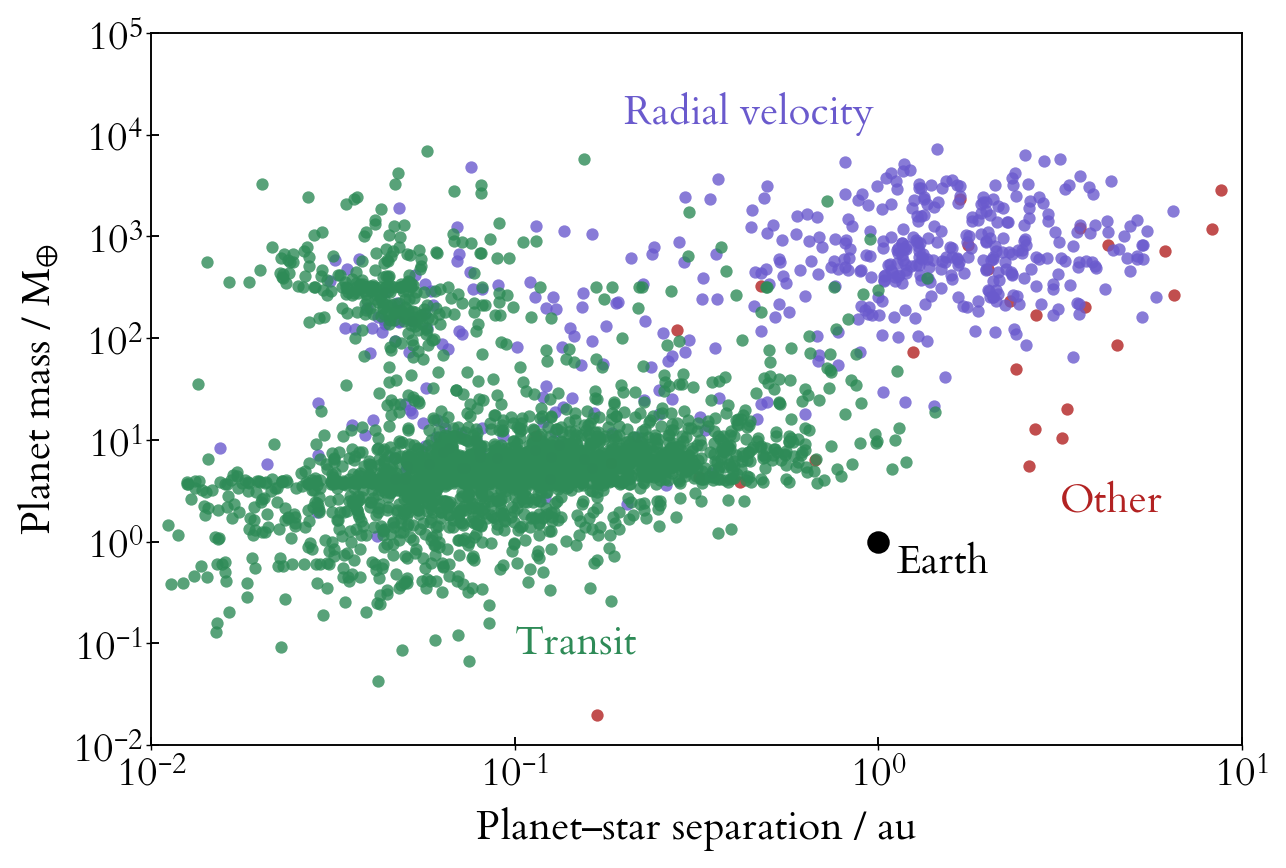

In [7]:
# make radius-separation chart

pyplot()

autofig("radius-separation", Normal) do
    x = :SEP
    y = :MASS
    mycols = d[[:PLANETDISCMETH, x, y]]
    clean = mycols[completecases(mycols), :]
    clamp!(clean[x], eps(), Inf)
    clamp!(clean[y], eps(), Inf)
    p = plot(xaxis=("Planet–star separation / au", (0.01, 10), :log10), 
             xticks=[0.01, 0.1, 1, 10], 
             yaxis=(L"Planet mass / M$_⊕$", (1e-2, 1e5), :log10), 
             legend=false,
             markerstrokewidth=0,
             framestyle=:full)
    for subgroup in groupby(clean, :PLANETDISCMETH)
        method = string(subgroup[1, :PLANETDISCMETH])
        scatter!(subgroup[x], subgroup[y],
                 markerstrokewidth=0,
                 alpha=0.8,
                 c=color_dict[method])
    end
    
    annotate_color!(10.0^0.5, 10.0^0.4, "Other", colors[1])
    annotate_color!(10.0^(-0.7), 10.0^4.2, "Radial velocity", colors[2])
    annotate_color!(1e-1, 1e-1, "Transit", colors[3])
    scatter!([1.0], [1.0], c=:black, markersize=6)
    annotate_color!(10.0^0.05, 10.0^(-0.2), "Earth", :black)
    p
end;

## Mass--radius diagram

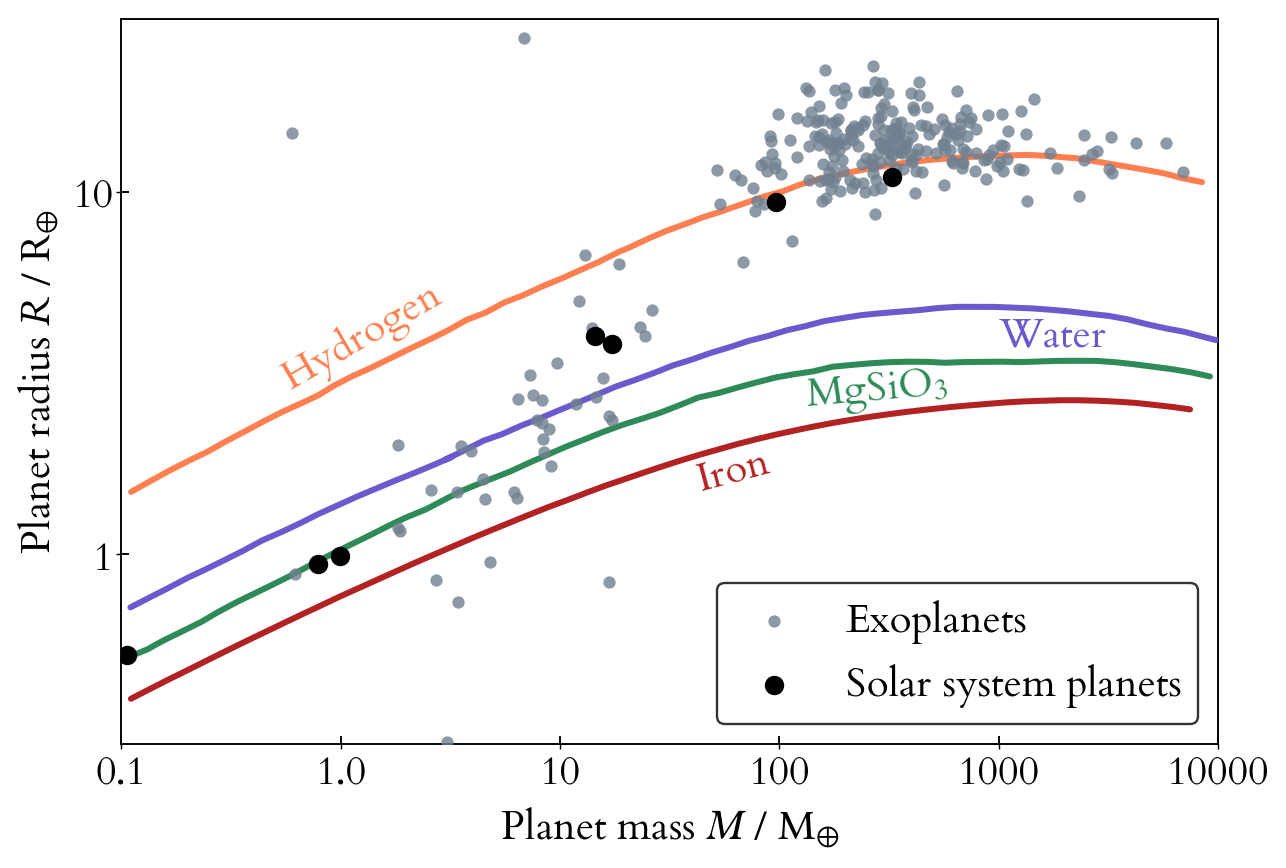

In [8]:
# make mass-radius diagram on the curves from Rogers & Seager 2012
autofig("mass-radius-rogers-seager", Normal) do
    fe = DataFrame(load("figdata/mr-diagram-rogers-seager/fe.csv"))
    hydrogen = DataFrame(load("figdata/mr-diagram-rogers-seager/hydrogen.csv"))
    water = DataFrame(load("figdata//mr-diagram-rogers-seager/water.csv"))
    mgsio3 = DataFrame(load("figdata/mr-diagram-rogers-seager/mgsio3_pv.csv"))
    solarsystem = DataFrame(load("figdata/mr-diagram-rogers-seager/solar-system-planets.csv"))

    x = :M_Mearth
    y = :R_Rearth
    
    foreach((fe, hydrogen, water, mgsio3, solarsystem)) do df
        clamp!(df[x], eps(), Inf)
        clamp!(df[y], eps(), Inf)
    end

    p = plot(xaxis = (L"Planet mass $M$ / M$_⊕$", (0.1, 1e4), :log10),
        yaxis = (L"Planet radius $R$ / R$_⊕$", (0.3, 30), :log10),
        yticks = [1, 10],
        xformatter = x -> (x <= 1 ? x : trunc(Int,x)),
        yformatter = y -> trunc(Int, y),
        framestyle = :box)
    
    plot!(fe[x], fe[y], c=:firebrick, label="")
    annotate_color!(40, 1.7, "Iron", :firebrick, rotation=15)

    plot!(hydrogen[x], hydrogen[y], c=:coral, label="")
    annotate_color!(0.5, 4, "Hydrogen", :coral, rotation=30)

    plot!(mgsio3[x], mgsio3[y], c=:seagreen, label="")
    annotate_color!(130, 2.8, L"MgSiO$_3$", :seagreen, rotation=5)

    plot!(water[x], water[y], c=:slateblue, label="")
    annotate_color!(1000, 4, "Water", :slateblue)
    
    mycols = d[[:MASS, :R, :MSINI]] # include msini so we only plot planets with 
    clean = mycols[completecases(mycols), :]
    clamp!(clean[:MASS], eps(), Inf)
    clamp!(clean[:R], eps(), Inf)
    clamp!(clean[:MSINI], eps(), Inf)
    scatter!(clean[:MASS], clean[:R], markerstrokewidth=0, c=:slategray, alpha=0.8, label="Exoplanets")
    
    scatter!(solarsystem[x], solarsystem[y], c=:black, markersize=5, label="Solar system planets")
end;

## Phase diagram of water

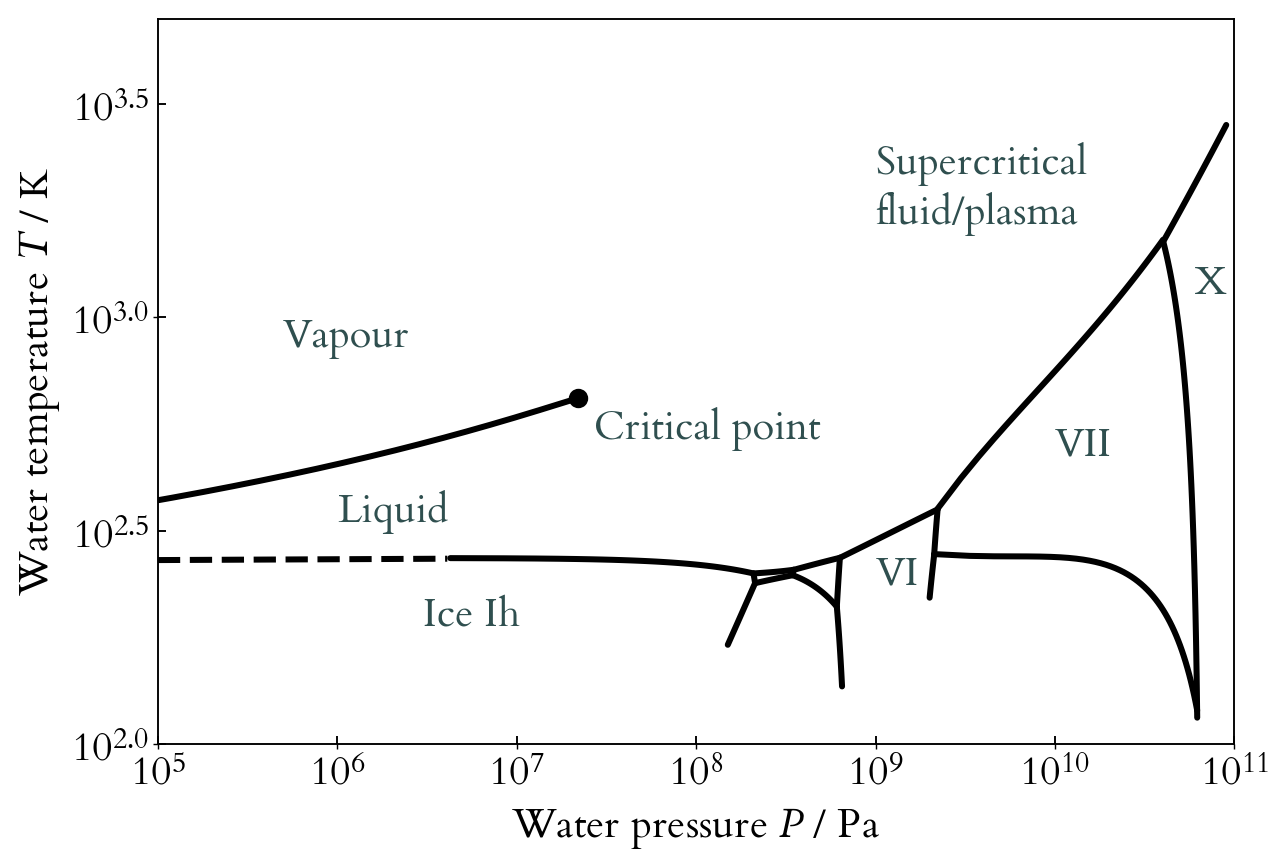

In [24]:
@recipe function plot(b::WaterData.PhaseBoundary)
    seriestype := :line
    color --> :black
    label --> ""
    
    P = clamp.(b.P, eps(), Inf)
    T = clamp.(b.T, eps(), Inf)

    P, T
end

autofig("water-phase-diagram", Normal) do
    # pull in the EOS data
    eosgrid = WaterData.load_full_eos()["grid"]
    phaseboundaries = WaterData.load_phase_boundaries()["boundaries"]
    evapboundary = phaseboundaries["iapws"]
    otherboundaries = phaseboundaries["dunaeva"]
    Plims = (1e5, 1e11)
    Tlims = (100, 5000)

    # vapour curve
    p = plot(evapboundary, 
             xaxis=(:log10, Plims, L"Water pressure $P$ / Pa"),
             yaxis=(:log10, Tlims, L"Water temperature $T$ / K"),
             framestyle = :box)

    # dot at critical point
    Pcrit = WaterData.Pc
    Tcrit = WaterData.Tc
    scatter!([Pcrit], [Tcrit], markershape=:circle, label="", markersize=5, c=:black)

    # phase boundaries
    plot!([1e5, 4.1e6], [2.7e2, 2.72e2], c=:black, ls=:dash, label="")
    foreach(plot!, otherboundaries)

    # region labels
    annotate_color!(1e6, 3.5e2, "Liquid", :darkslategray)
    annotate_color!(5e5, 9e2, "Vapour", :darkslategray)
    annotate_color!(1e9, 2e3, "Supercritical\nfluid/plasma", :darkslategray)
    annotate_color!(3e6, 2e2, "Ice Ih", :darkslategray)
    annotate_color!(1e9, 2.5e2, "VI", :darkslategray)
    annotate_color!(1e10, 5e2, "VII", :darkslategray)
    annotate_color!(6e10, 1.2e3, "X", :darkslategray)
    annotate_color!(Pcrit+5e6, Tcrit-1e2, "Critical point", :darkslategray)
    p
end;

## PREM vs Earth-like model

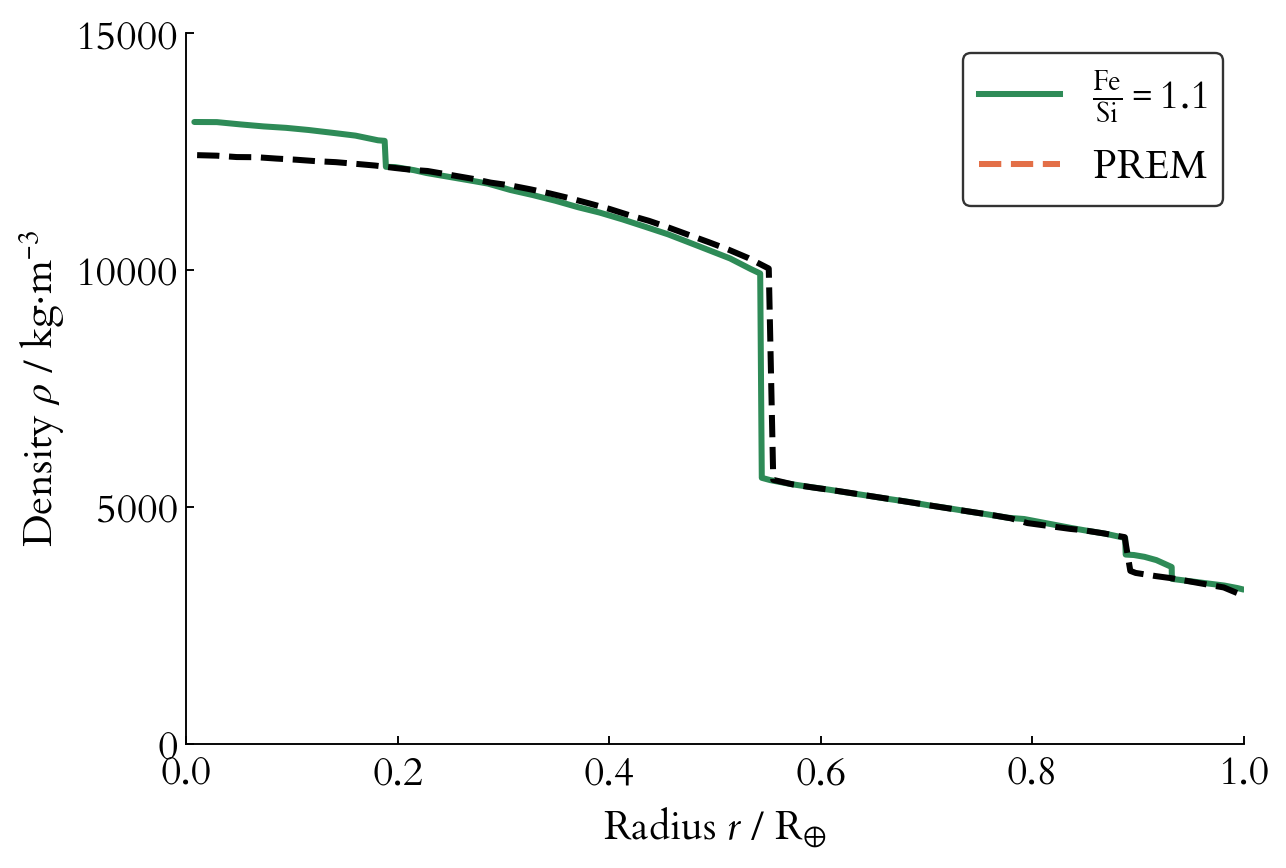

In [23]:
autofig("density-profile-PREM-comparison", Normal) do
    prem = DataFrame(load("figdata/PREM/prem.csv"))
    model = DataFrame(load("figdata/PREM/model.csv"))
    
    R_earth = maximum(prem[:radius])

    plot(prem[:radius]/R_earth, prem[:density],
        xaxis=(L"Radius $r$ / R$_⊕$", (0, 1)),
        yaxis=(L"Density $ρ$ / kg$⋅$m$^{-3}$", (0, 15000)),
        yticks=[0, 5000, 10000, 15000],
        c=:seagreen,
        label=L"\mathrm{\frac{Fe}{Si}} = 1.1")
    
    plot!(model[:radius]/R_earth, model[:density], 
        linestyle=:dash, linecolor=:black, label="PREM")
end;